# Computer Vision Project Main Script

In [1]:
# Importing packages
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from random import randint
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Reshape, Permute
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
import models
print('importing finished')

D:\Users\joren\Anaconda3\envs\unet\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\joren\Anaconda3\envs\unet\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\joren\Anaconda3\envs\unet\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\joren\Anaconda3\envs\unet\lib\site-packages\tensorflow\python\frame

importing finished


# 1. Loading Data

In [2]:
# parameters that you should set before running this script
root_dir = os.getcwd()
# parameters that you should set before running this script
# select class, this default should yield 1489 training and 1470 validation images
filter = ['aeroplane', 'car', 'chair', 'dog', 'bird']

# please replace with the location on your laptop where you unpacked the tarball
voc_root_folder = os.path.join(root_dir, 'VOCtrainval_11-May-2009/VOCdevkit')
image_size = 256    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)

# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]

x_train, y_train = models.build_classification_dataset(train_files, image_size, filter, voc_root_folder )
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = models.build_classification_dataset(val_files, image_size, filter, voc_root_folder)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

print(x_train.shape)
print(y_train.shape)
# from here, you can start building your model
# you will only need x_train and x_val for the autoencoder
# you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)

1489 training images from 5 classes
1470 validation images from 5 classes
(1489, 256, 256, 3)
(1489, 5)


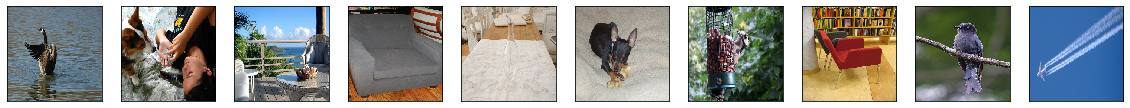

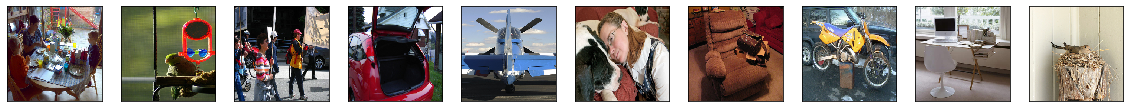

In [3]:
n = 10 # how many images we will display
train_im = [randint(0, 1489) for p in range(n)]
val_im = [randint(0, 1470) for p in range(n)]

plt.figure(figsize=(20, 8))
for i in range(n):
    # display train 
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[train_im[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.figure(figsize=(20, 4))
for i in range(n):  
    # display test
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[val_im[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# 2. Auto Encoders

In [3]:
# Building the encoding part of the autoencoder
keras.backend.clear_session()
models.build_autoenoder(in_shape=(256, 256, 3), n_blocks=4)
autoencoder.save(os.path.join(root_dir,'16x16x8untrained.h5' ))
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, '16x16x8_log.csv'), separator=',', append=False)]
autoencoder.fit(x_train, x_train, epochs=50, shuffle=True, validation_data=(x_val, x_val), callbacks=custom_callbacks)
autoencoder.save(os.path.join(root_dir,'16x16x8.h5'))

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 21s 14ms/step - loss: 0.0693 - val_loss: 0.0468
Epoch 2/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0339 - val_loss: 0.0260
Epoch 3/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0241 - val_loss: 0.0228
Epoch 4/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 5/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0219 - val_loss: 0.0211
Epoch 6/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 7/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0209 - val_loss: 0.0201
Epoch 8/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0204 - val_loss: 0.0201
Epoch 9/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 10/50
1489

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
__________

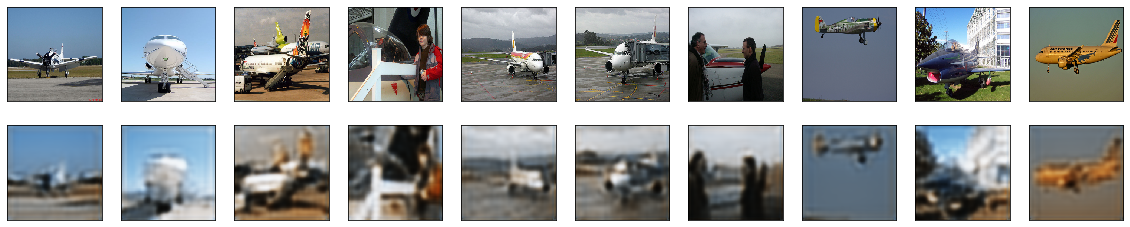

In [61]:
keras.backend.clear_session()
# encode and decode some images
autoencoder = load_model('16x16x8.h5')
autoencoder.layers
autoencoder.summary()
decoded_imgs = autoencoder.predict(x_val)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
keras.backend.clear_session()
models.build_autoenoder(in_shape=(256, 256, 3), n_blocks=3)
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, '32x32x8_log.csv'), separator=',', append=False)]

autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, shuffle=True, validation_data=(x_val, x_val), callbacks=custom_callbacks)
autoencoder.save(os.path.join(root_dir,'32x32x8.h5'))

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 17s 11ms/step - loss: 0.0457 - val_loss: 0.0209
Epoch 2/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0193 - val_loss: 0.0177
Epoch 3/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 4/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0155 - val_loss: 0.0146
Epoch 5/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 6/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 7/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 8/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 9/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 10/50
1489

In [6]:
keras.backend.clear_session()
models.build_autoenoder(in_shape=(256, 256, 3), n_blocks=2)
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, '64x64x8_log.csv'), separator=',', append=False)]

autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, shuffle=True, validation_data=(x_val, x_val), callbacks=custom_callbacks)
autoencoder.save(os.path.join(root_dir,'64x64x8.h5'))

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0484 - val_loss: 0.0221
Epoch 2/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0178 - val_loss: 0.0149
Epoch 3/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 4/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 5/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 6/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 7/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 8/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 9/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 10/50
1489

(1470, 256, 256, 3)


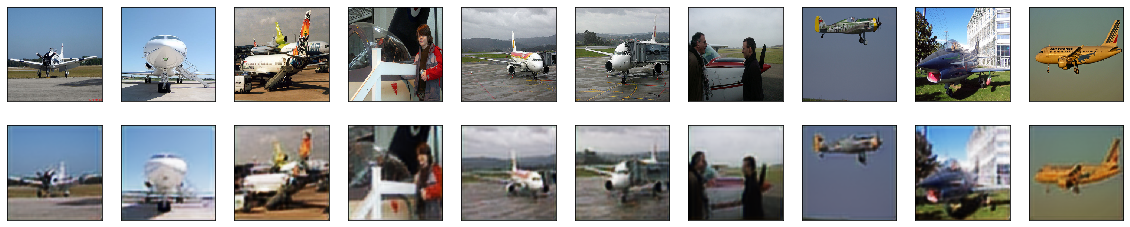

In [8]:
keras.backend.clear_session()
# encode and decode some images
autoencoder = load_model('32x32x8.h5')
decoded_imgs = autoencoder.predict(x_val)

print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(1470, 256, 256, 3)


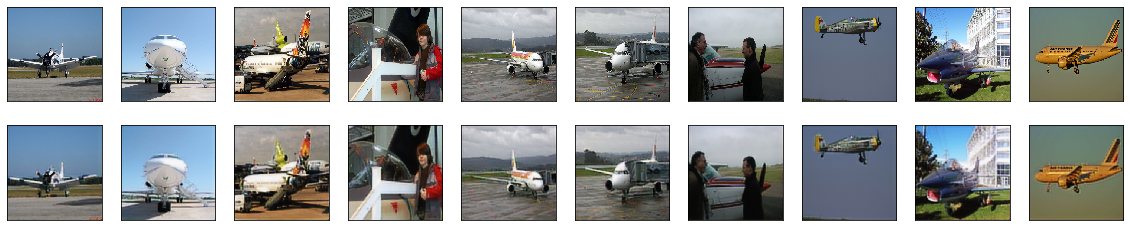

In [9]:
keras.backend.clear_session()
# encode and decode some images
autoencoder = load_model('64x64x8.h5')
decoded_imgs = autoencoder.predict(x_val)

print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
keras.backend.clear_session()
models.build_autoenoder(in_shape=(256, 256, 3), n_blocks=5)
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, '8x8x8_log.csv'), separator=',', append=False)]

autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, shuffle=True, validation_data=(x_val, x_val), callbacks=custom_callbacks)
autoencoder.save(os.path.join(root_dir,'8x8x8.h5'))

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 17s 11ms/step - loss: 0.0693 - val_loss: 0.0529
Epoch 2/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0396 - val_loss: 0.0307
Epoch 3/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0294 - val_loss: 0.0281
Epoch 4/50
1489/1489 [==============================] - 15s 10ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 5/50
1489/1489 [==============================] - 16s 10ms/step - loss: 0.0269 - val_loss: 0.0259
Epoch 6/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0262 - val_loss: 0.0255
Epoch 7/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0257 - val_loss: 0.0250
Epoch 8/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0253 - val_loss: 0.0248
Epoch 9/50
1489/1489 [==============================] - 16s 11ms/step - loss: 0.0250 - val_loss: 0.0242
Epoch 10/50
1489

(1470, 256, 256, 3)


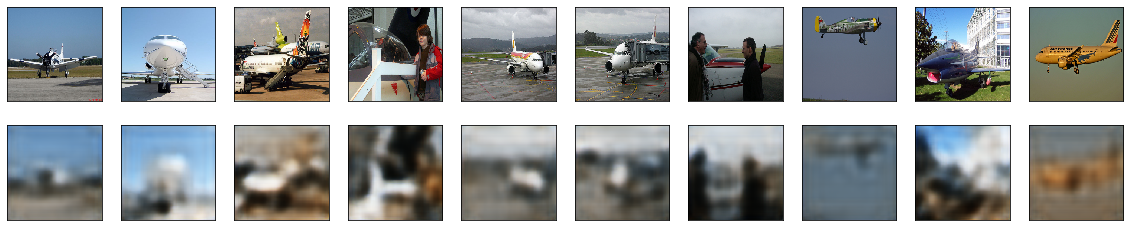

In [11]:
keras.backend.clear_session()
# encode and decode some images
autoencoder = load_model('8x8x8.h5')
decoded_imgs = autoencoder.predict(x_val)

print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

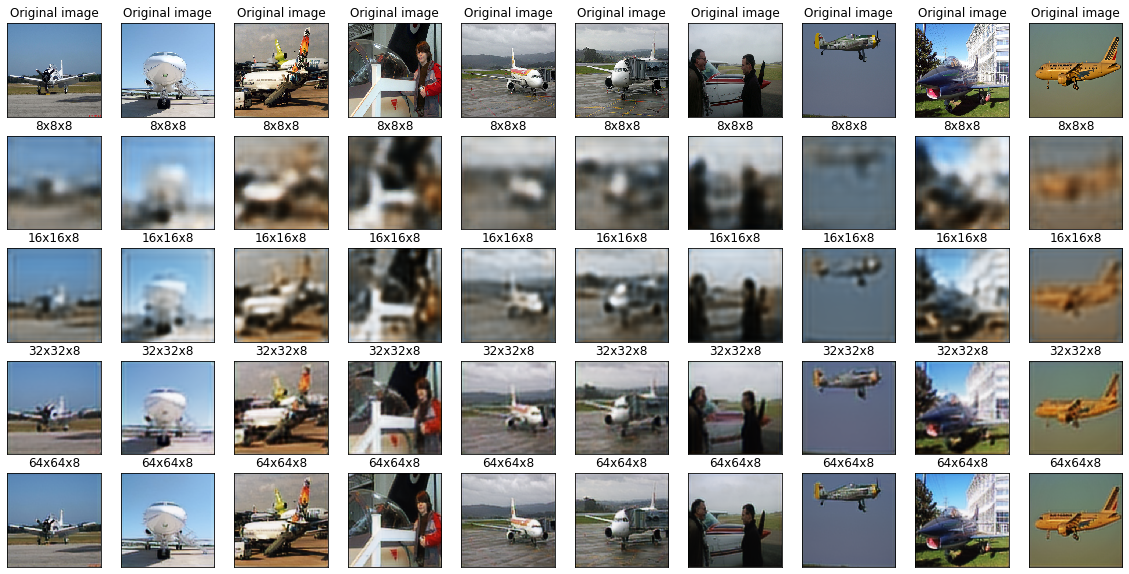

In [7]:
keras.backend.clear_session()
# Show images from all encoders
auto1 = load_model('8x8x8.h5')
decoded1 = auto1.predict(x_val)
auto2 = load_model('16x16x8.h5')
decoded2 = auto2.predict(x_val)
auto3 = load_model('32x32x8.h5')
decoded3 = auto3.predict(x_val)
auto4 = load_model('64x64x8.h5')
decoded4 = auto4.predict(x_val)

rows = ['Row {}'.format(row) for row in ['original images','8x8x8', '16x16x8', '32x32x8', '64x64x8']]

n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('Original image')

    # display reconstruction auto 1
    ax = plt.subplot(5, n, i + n + 1)
    plt.imshow(decoded1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('8x8x8')
    
    # display reconstruction auto 2
    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.imshow(decoded2[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('16x16x8')
    
    # display reconstruction auto 3
    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.imshow(decoded3[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('32x32x8')
    
    # display reconstruction auto 4
    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.imshow(decoded4[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('64x64x8')
plt.show()


In [8]:
# Loading the network
autoencoder = load_model('16x16x8.h5')
autoencoder.layers
autoencoder.summary()

autoencoder = load_model('8x8x8.h5')
autoencoder.layers
autoencoder.summary()

autoencoder = load_model('32x32x8.h5')
autoencoder.layers
autoencoder.summary()

autoencoder = load_model('64x64x8.h5')
autoencoder.layers
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
__________

In [34]:
# Loading the network
autoencoder = load_model('16x16x8.h5')
autoencoder.layers
autoencoder.summary()

encoder = Model(autoencoder.input, autoencoder.layers[8].output)
encoder.layers
encoder.summary()
encoder.save(os.path.join(root_dir,'encoder.h5'))

autoencoder = load_model('16x16x8untrained.h5')
autoencoder.layers
autoencoder.summary()

encoder = Model(autoencoder.input, autoencoder.layers[8].output)
encoder.layers
encoder.summary()
encoder.save(os.path.join(root_dir,'encoderuntrained.h5'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
__________

# 3. Classification

In [20]:
# create 3 new networks, 1 to fully retrain, 1 to train only 1 layer on, one to retrain further on
# Train only last layer
#
encoder = load_model('encoder.h5')
for layer in encoder.layers:
    layer.trainable = False
new_class = Sequential()
new_class.add(encoder)
new_class.add(Flatten())
new_class.add(Dense(5, activation='softmax', init='normal'))
new_class.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_class.summary()
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, 'classification_freeze_log2.csv'), separator=',', append=False)]

new_class.fit(x_train, y_train, epochs=100, shuffle=True, validation_data=(x_val, y_val), callbacks=custom_callbacks)
new_class.save(os.path.join(root_dir,'freeze2.h5'))

d:\users\joren\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="softmax", kernel_initializer="normal")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_16 (Model)             (None, 16, 16, 8)         2776      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 13,021
Trainable params: 10,245
Non-trainable params: 2,776
_________________________________________________________________
Train on 1489 samples, validate on 1470 samples
Epoch 1/100
1489/1489 [==============================] - 18s 12ms/step - loss: 1.6977 - acc: 0.2559 - val_loss: 1.6998 - val_acc: 0.2456
Epoch 2/100
1489/1489 [==============================] - 18s 12ms/step - loss: 1.6826 - acc: 0.2559 - val_loss: 1.6933 - val_acc: 0.2456
Epoch 3/100
1489/1489 [==============================] - 17s 11ms/step - los

Epoch 55/100
1489/1489 [==============================] - 17s 12ms/step - loss: 1.5486 - acc: 0.3956 - val_loss: 1.5772 - val_acc: 0.3667
Epoch 56/100
1489/1489 [==============================] - 17s 12ms/step - loss: 1.5472 - acc: 0.3835 - val_loss: 1.5764 - val_acc: 0.3646
Epoch 57/100
1489/1489 [==============================] - 17s 11ms/step - loss: 1.5455 - acc: 0.4063 - val_loss: 1.5755 - val_acc: 0.3680
Epoch 58/100
1489/1489 [==============================] - 18s 12ms/step - loss: 1.5447 - acc: 0.3909 - val_loss: 1.5742 - val_acc: 0.3667
Epoch 59/100
1489/1489 [==============================] - 17s 11ms/step - loss: 1.5430 - acc: 0.4030 - val_loss: 1.5727 - val_acc: 0.3823
Epoch 60/100
1489/1489 [==============================] - 17s 11ms/step - loss: 1.5413 - acc: 0.4023 - val_loss: 1.5721 - val_acc: 0.3707
Epoch 61/100
1489/1489 [==============================] - 18s 12ms/step - loss: 1.5404 - acc: 0.3895 - val_loss: 1.5710 - val_acc: 0.3741
Epoch 62/100
1489/1489 [==========

In [21]:
# create second network fully retrain 
encoder = load_model('encoderuntrained.h5')

new_class = Sequential()
new_class.add(encoder)
new_class.add(Flatten())
new_class.add(Dense(5, activation='softmax', init='normal'))
new_class.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_class.summary()
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, 'classification_no_freeze_log2.csv'), separator=',', append=False)]
new_class.fit(x_train, y_train, epochs=100, shuffle=True, validation_data=(x_val, y_val), callbacks=custom_callbacks)
new_class.save(os.path.join(root_dir,'no_freeze2.h5'))

d:\users\joren\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="softmax", kernel_initializer="normal")`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_17 (Model)             (None, 16, 16, 8)         2776      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 13,021
Trainable params: 13,021
Non-trainable params: 0
_________________________________________________________________
Train on 1489 samples, validate on 1470 samples
Epoch 1/100
1489/1489 [==============================] - 35s 23ms/step - loss: 1.6930 - acc: 0.2411 - val_loss: 1.6934 - val_acc: 0.2456
Epoch 2/100
1489/1489 [==============================] - 33s 22ms/step - loss: 1.6654 - acc: 0.2619 - val_loss: 1.6519 - val_acc: 0.2925
Epoch 3/100
1489/1489 [==============================] - 33s 22ms/step - loss: 1

Epoch 55/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1830 - acc: 0.9657 - val_loss: 4.0484 - val_acc: 0.3735
Epoch 56/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.2104 - acc: 0.9671 - val_loss: 3.9071 - val_acc: 0.3735
Epoch 57/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1855 - acc: 0.9704 - val_loss: 3.8850 - val_acc: 0.3857
Epoch 58/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1605 - acc: 0.9664 - val_loss: 4.0957 - val_acc: 0.3905
Epoch 59/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1696 - acc: 0.9718 - val_loss: 3.8138 - val_acc: 0.3918
Epoch 60/100
1489/1489 [==============================] - 35s 24ms/step - loss: 0.1858 - acc: 0.9698 - val_loss: 3.9201 - val_acc: 0.3898
Epoch 61/100
1489/1489 [==============================] - 34s 23ms/step - loss: 0.1905 - acc: 0.9718 - val_loss: 3.9231 - val_acc: 0.3878
Epoch 62/100
1489/1489 [==========

In [22]:
# Create third network start from encoder and train further on
encoder = load_model('encoder.h5')

new_class = Sequential()
new_class.add(encoder)
new_class.add(Flatten())
new_class.add(Dense(5, activation='softmax', init='normal'))
new_class.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_class.summary()
custom_callbacks = [
            keras.callbacks.History(),
            keras.callbacks.CSVLogger(os.path.join(root_dir, 'classification_no_freeze_train_further_log2.csv'), separator=',', append=False)]
new_class.fit(x_train, y_train, epochs=100, shuffle=True, validation_data=(x_val, y_val), callbacks=custom_callbacks)
new_class.save(os.path.join(root_dir,'no_freeze_train_further_2.h5'))

d:\users\joren\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="softmax", kernel_initializer="normal")`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_16 (Model)             (None, 16, 16, 8)         2776      
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 13,021
Trainable params: 13,021
Non-trainable params: 0
_________________________________________________________________
Train on 1489 samples, validate on 1470 samples
Epoch 1/100
1489/1489 [==============================] - 34s 23ms/step - loss: 1.6919 - acc: 0.2304 - val_loss: 1.6835 - val_acc: 0.2721
Epoch 2/100
1489/1489 [==============================] - 33s 22ms/step - loss: 1.6339 - acc: 0.2814 - val_loss: 1.6143 - val_acc: 0.2973
Epoch 3/100
1489/1489 [==============================] - 33s 22ms/step - loss: 1

Epoch 55/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.2108 - acc: 0.9651 - val_loss: 4.0198 - val_acc: 0.4088
Epoch 56/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1766 - acc: 0.9704 - val_loss: 4.0279 - val_acc: 0.4102
Epoch 57/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1954 - acc: 0.9657 - val_loss: 4.1080 - val_acc: 0.4265
Epoch 58/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1854 - acc: 0.9691 - val_loss: 3.9811 - val_acc: 0.4075
Epoch 59/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1830 - acc: 0.9671 - val_loss: 4.0309 - val_acc: 0.4020
Epoch 60/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1729 - acc: 0.9691 - val_loss: 4.1053 - val_acc: 0.4102
Epoch 61/100
1489/1489 [==============================] - 33s 22ms/step - loss: 0.1877 - acc: 0.9644 - val_loss: 3.8600 - val_acc: 0.4061
Epoch 62/100
1489/1489 [==========

# 4. Visualisation

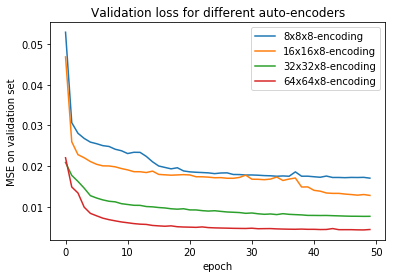

In [4]:
# create plots of the loss of the different autoencoders
import pandas as pd

cols = ['epoch', 'loss', 'val_loss']

log8 = pd.read_csv("8x8x8_log.csv") 
log16= pd.read_csv("16x16x8_log.csv") 
log32= pd.read_csv("32x32x8_log.csv") 
log64= pd.read_csv("64x64x8_log.csv") 

plt.figure()
plt.plot(log8['val_loss'])
plt.plot(log16['val_loss'])
plt.plot(log32['val_loss'])
plt.plot(log64['val_loss'])
plt.legend(['8x8x8-encoding','16x16x8-encoding','32x32x8-encoding','64x64x8-encoding'])
plt.xlabel('epoch')
plt.ylabel('MSE on validation set')
plt.title('Validation loss for different auto-encoders')
plt.show()

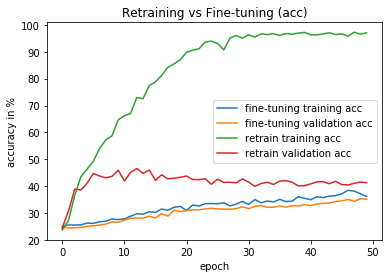

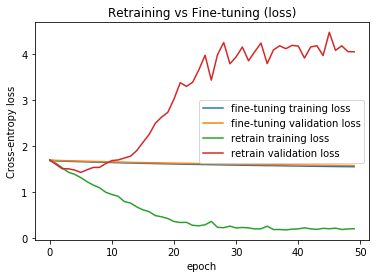

In [5]:
# create plots of the loss of the different segmentations
import pandas as pd

cols = ['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

freeze = pd.read_csv("classification_freeze_log.csv") 
no_freeze = pd.read_csv("classification_no_freeze_log.csv") 

plt.figure
plt.plot(freeze['acc']*100)
plt.plot(freeze['val_acc']*100)
plt.plot(no_freeze['acc']*100)
plt.plot(no_freeze['val_acc']*100)
plt.xlabel('epoch')
plt.ylabel('accuracy in %')
plt.title('Retraining vs Fine-tuning (acc)')
plt.legend(['fine-tuning training acc', 'fine-tuning validation acc', 'retrain training acc', 'retrain validation acc' ])
plt.show()

plt.figure
plt.plot(freeze['loss'])
plt.plot(freeze['val_loss'])
plt.plot(no_freeze['loss'])
plt.plot(no_freeze['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.title('Retraining vs Fine-tuning (loss)')
plt.legend(['fine-tuning training loss', 'fine-tuning validation loss', 'retrain training loss', 'retrain validation loss' ])
plt.show()

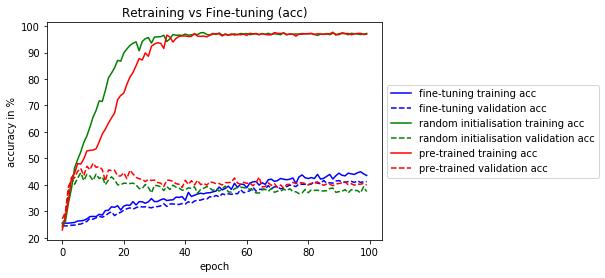

Fine-tuning best =  41.70068028224569 at epoch  85
random best =  44.62585036446448 6
pre-trained best =  48.23129252714365 10


In [31]:
# create plots of the loss of the different segmentations
import pandas as pd

cols = ['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

freeze = pd.read_csv("classification_freeze_log2.csv") 
no_freeze = pd.read_csv("classification_no_freeze_log2.csv") 
part_retrain = pd.read_csv("classification_no_freeze_train_further_log2.csv")
fig = plt.figure()
plt.plot(freeze['acc']*100, color='b', label = 'fine-tuning training acc')
plt.plot(freeze['val_acc']*100, color='b', linestyle='dashed', label = 'fine-tuning validation acc' )
plt.plot(no_freeze['acc']*100, color='g', label = 'random initialisation training acc')
plt.plot(no_freeze['val_acc']*100, color='g', linestyle='dashed', label = 'random initialisation validation acc')
plt.plot(part_retrain['acc']*100, color='r', label = 'pre-trained training acc')
plt.plot(part_retrain['val_acc']*100, color='r', linestyle='dashed', label = 'pre-trained validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy in %')
plt.title('Retraining vs Fine-tuning (acc)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
fig.savefig('training_curve_segmentation2.eps', format='eps', dpi=1000)
print('Fine-tuning best = ', max(freeze['val_acc'])*100, 'at epoch ', np.argmax(freeze['val_acc']))
print('random best = ', max(no_freeze['val_acc'])*100, np.argmax(no_freeze['val_acc']))
print('pre-trained best = ', max(part_retrain['val_acc'])*100, np.argmax(part_retrain['val_acc']))